Convert Pascal VOC training data to Haar training data

In [1]:
import os

In [7]:
def create_boxes(filename):
    boxes = []

    input = open(filename, 'r')
    lines = input.readlines()

    for i, line in enumerate(lines):
        if 'xmin' in line:
            line2, line3, line4 = lines[i + 1], lines[i + 2], lines[i + 3]
            
            xmin = int(line[9:-8])
            ymin = int(line2[9:-8])
            xmax = int(line3[9:-8])
            ymax = int(line4[9:-8])
            
            x, y = xmin, ymin
            width = xmax - xmin 
            height = ymax - ymin
            
            boxes.append(str(x) + ' ' + str(y) + ' ' +  str(width) + ' ' + str(height))
    
    return boxes

In [8]:
def create_pos_txt(pascal_training_X):
    all_boxes = []
    with open('pos.txt', 'w') as f:
        for x in pascal_training_X:
            boxes = create_boxes(x)
            f.write('positive/' + x[x.rfind('/') + 1:-3] + 'jpg ' + str(len(boxes)))
            for box in boxes:
                f.write(' ' + box)
            f.write('\n')
            all_boxes.extend(boxes)
    return all_boxes

In [9]:
def create_neg_txt(directory):
    with open('neg.txt', 'w') as f:
        for filename in os.listdir(directory):
            f.write('negative/' + filename + '\n')

In [10]:
pascal_training_X = [
    '../labeling_real/annotations/2021_07_19/E3-A.xml',
    '../labeling_real/annotations/2021_07_19/P6-C.xml',
    '../labeling_real/annotations/2021_08_05/ECages/E8_B.xml',
    '../labeling_real/annotations/2021_08_05/PCages/P9_A.xml',
    '../labeling_real/annotations/2021_08_20/ECage/E9_A.xml',
    '../labeling_real/annotations/2021_08_20/PCage/P6_C.xml',
    '../labeling_real/annotations/2021_09_17/IMG_2009.xml',
    '../labeling_real/annotations/Census 2021/10-18/IMG_6550.xml'
]

In [14]:
all_boxes = create_pos_txt(pascal_training_X)
create_neg_txt('./negative')

Object Detection Model

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

In [2]:
def draw_rectangles(haystack_img, rectangles):
    # these colors are actually BGR
    line_color = (0, 255, 0)
    line_type = cv2.LINE_4

    count = 0
    for (x, y, w, h) in rectangles:
        if w > 80 or h > 80:
            continue
        count += 1
        # determine the box positions
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        # draw the box
        cv2.rectangle(haystack_img, top_left, bottom_right, line_color, lineType=line_type)

    return haystack_img, count

In [3]:
def k_means(img):   
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 1
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))   
    return result_image

def contour_detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    canny = cv2.Canny(blur, 0, 0, 3, L2gradient=True)
    dilated = cv2.dilate(canny, (5,5), iterations=50)

    (contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse=True)
    
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(img, sorted_contours, 0, (255, 0, 0), 2)
    return img, sorted_contours

def segment_corner(img):
#     img = cv2.imread(filename) # Read in your image
    k_means_img = k_means(img)
    contours_img, contours = contour_detect(k_means_img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = np.zeros_like(thresh)
    cv2.drawContours(mask, contours, 0, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]
    
    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]

    return out

In [4]:
cascade_fly = cv2.CascadeClassifier('cascade/cascade.xml')

In [5]:
def detect_flies(filename, output_name):
    print("BEGIN " + filename)
    start = timeit.default_timer()
    img = cv2.imread(filename) # Read in your image
    cropped_img = segment_corner(img)
    cropped_img = segment_corner(cropped_img)
    print("Cropped " + filename)
    rectangles = cascade_fly.detectMultiScale(cropped_img)
    print("Performed detection for " + filename)
    detection_image, count = draw_rectangles(cropped_img, rectangles)
    print("# of Drosophila:  " + str(count))
    cv2.imwrite(output_name, detection_image)
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    print("FINISHED " + filename + "\n")
    return detection_image

Using Object Detection Model

In [6]:
directory = "./ECages"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    detect_flies(f, "model_v1.1_" + filename)

BEGIN ./ECages/E10_A.JPG
Cropped ./ECages/E10_A.JPG
Performed detection for ./ECages/E10_A.JPG
# of Drosophila:  13
Time:  3.1811185999999907
FINISHED ./ECages/E10_A.JPG

BEGIN ./ECages/E10_B.JPG
Cropped ./ECages/E10_B.JPG
Performed detection for ./ECages/E10_B.JPG
# of Drosophila:  201
Time:  6.100526099999996
FINISHED ./ECages/E10_B.JPG

BEGIN ./ECages/E11_A.JPG
Cropped ./ECages/E11_A.JPG
Performed detection for ./ECages/E11_A.JPG
# of Drosophila:  26
Time:  1.710666400000008
FINISHED ./ECages/E11_A.JPG

BEGIN ./ECages/E11_B.JPG
Cropped ./ECages/E11_B.JPG
Performed detection for ./ECages/E11_B.JPG
# of Drosophila:  15
Time:  1.736532000000011
FINISHED ./ECages/E11_B.JPG

BEGIN ./ECages/E11_C.JPG
Cropped ./ECages/E11_C.JPG
Performed detection for ./ECages/E11_C.JPG
# of Drosophila:  329
Time:  7.125557000000015
FINISHED ./ECages/E11_C.JPG

BEGIN ./ECages/E11_D.JPG
Cropped ./ECages/E11_D.JPG
Performed detection for ./ECages/E11_D.JPG
# of Drosophila:  481
Time:  4.455253699999986
FINIS

KeyboardInterrupt: 

### --- EXPERIMENTAL CODE BELOW --- 
Cropping Methods

In [379]:
def k_means(img):   
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.cvtColor(blur,cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 1
    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))   
    return result_image

In [408]:
def contour_detect(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    canny = cv2.Canny(blur, 0, 0, 3, L2gradient=True)
    dilated = cv2.dilate(canny, (5,5), iterations=50)

    (contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    sorted_contours= sorted(contours, key=cv2.contourArea, reverse=True)
    
    cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(img, sorted_contours, 0, (255, 0, 0), 2)
    return img, sorted_contours

In [409]:
def crop(img, kmeans_img, contours):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = np.zeros_like(thresh)
    cv2.drawContours(mask, contours, 0, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]
    
    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]

    return out

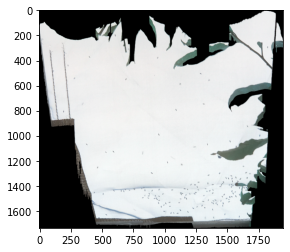

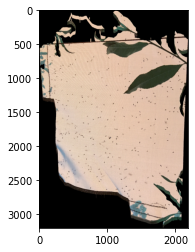

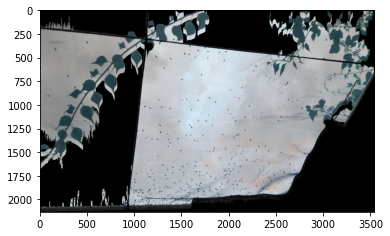

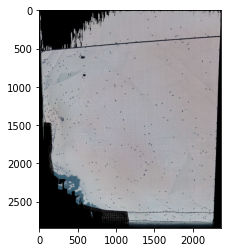

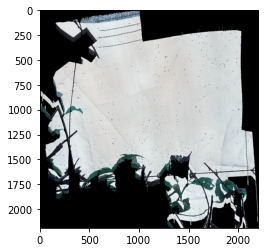

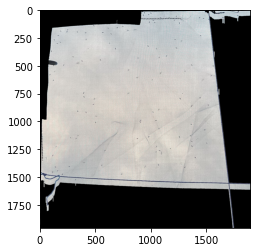

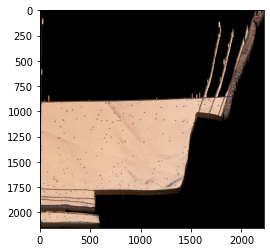

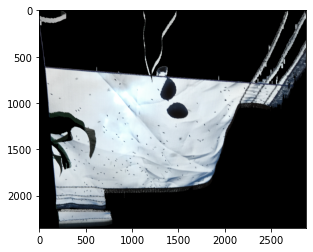

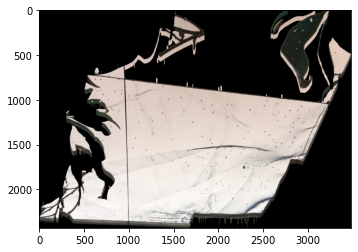

In [410]:
directory = "./positive"

images = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    img = cv2.imread(f)
    kmeans_img = k_means(img)
    contour_img, contours = contour_detect(kmeans_img)
    crop_img = crop(img, kmeans_img, contours)
    images.append(crop_img)

for ima in images:
    plt.figure()
    plt.imshow(ima)

### NOT IN USE
The code below are discarded methods not currenlty being explored

In [29]:
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    
    contours, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    parent = hiers[0, :, 3]
    hist = np.bincount(np.maximum(parent, 0))
    max_n_childs_idx = hist.argmax()
    
    mask = np.zeros_like(thresh) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contours, max_n_childs_idx, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[mask == 255] = img[mask == 255]

    # Now crop
    (y, x) = np.where(mask == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))
    out = out[topy:bottomy+1, topx:bottomx+1]
    
    return out